In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o")

In [8]:
class State(TypedDict):
    document: str
    summary: str
    sentiment: str
    key_points: str
    recommendation: str
    final_analysis: str

In [9]:
def get_summary(state: State):
    response = llm.invoke(
        f"Write a 3-sentence summary of this document in Korean {state["document"]}"
    )
    return {
        "summary": response.content,
    }


def get_sentiment(state: State):
    response = llm.invoke(
        f"Analyse the sentiment and tone of this document in Korean {state["document"]}"
    )
    return {
        "sentiment": response.content,
    }


def get_key_points(state: State):
    response = llm.invoke(
        f"List the 5 most important points of this document in Korean {state["document"]}"
    )
    return {
        "key_points": response.content,
    }


def get_recommendation(state: State):
    response = llm.invoke(
        f"Based on the document, list 3 recommended next steps in Korean {state["document"]}"
    )
    return {
        "recommendation": response.content,
    }


def get_final_analysis(state: State):
    response = llm.invoke(
        f"""
    Give me an analysis of the following report in Korean

    DOCUMENT ANALYSIS REPORT
    ========================

    EXECUTIVE SUMMARY:
    {state['summary']}

    SENTIMENT ANALYSIS:
    {state['sentiment']}

    KEY POINTS:
    {state.get("key_points", "")}

    RECOMMENDATIONS:
    {state.get('recommendation', "N/A")}
    """
    )
    return {
        "final_analysis": response.content,
    }

In [10]:
graph_builder = StateGraph(State)

graph_builder.add_node("get_summary", get_summary)
graph_builder.add_node("get_sentiment", get_sentiment)
graph_builder.add_node("get_key_points", get_key_points)
graph_builder.add_node("get_recommendation", get_recommendation)
graph_builder.add_node("get_final_analysis", get_final_analysis)


graph_builder.add_edge(START, "get_summary")
graph_builder.add_edge(START, "get_sentiment")
graph_builder.add_edge(START, "get_key_points")
graph_builder.add_edge(START, "get_recommendation")

graph_builder.add_edge("get_summary", "get_final_analysis")
graph_builder.add_edge("get_sentiment", "get_final_analysis")
graph_builder.add_edge("get_key_points", "get_final_analysis")
graph_builder.add_edge("get_recommendation", "get_final_analysis")

graph_builder.add_edge("get_final_analysis", END)


graph = graph_builder.compile()

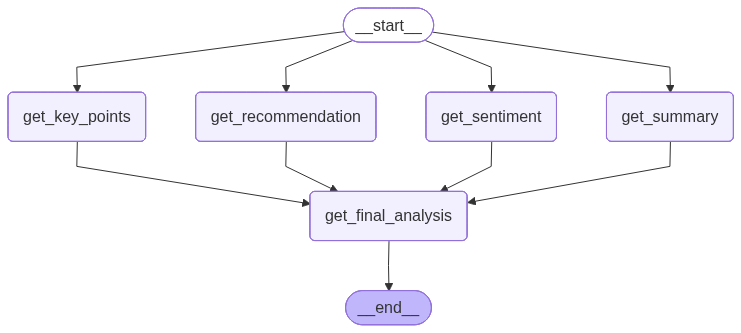

In [12]:
display(graph)

In [11]:
with open("README.md", "r", encoding="utf-8") as file:
    document = file.read()

for chunk in graph.stream(
    {"document": document},
    stream_mode="updates",
):
    print(chunk, "\n")

{'get_summary': {'summary': "이 문서는 '넥서스'라는 책을 읽고 주요 내용을 요약한 내용입니다. 책에서는 정보의 사회적 연결 고리 역할과 거짓 정보가 사람들을 묶는 매개체로 작용할 수 있음을 설명합니다. 또한, 허구적 정보가 진실에 비해 간단하고 매력적이며, 사회가 진실을 제한하여 질서를 유지하는 경향에 대해 논의합니다."}} 

{'get_sentiment': {'sentiment': '이 문서는 상당히 긍정적인 톤과 감정을 가지고 있습니다. 문서를 작성한 사람은 책을 읽고 요약하는 경험에 대해 매우 긍정적인 감정을 표현하고 있습니다. 글에서 종종 "상당히 좋은 것 같아요", "생각할 것들이 많고", "기억들이 다시 회상되고"와 같은 구절을 사용하여 독서 경험이 만족스럽고 의미 있는 것으로 느껴진다고 말하고 있습니다.\n\n또한, 문서 작성자는 자신의 독서 방법론(읽은 내용을 요약하고 질문을 만들어보는 것)이 기억에 도움이 되며 많은 생각을 하게 만든다는 점을 강조하고 있습니다. 이는 자기 계발과 지적 성장에 대한 긍정적인 태도를 나타냅니다.\n\n전체적으로 이 문서는 책 읽기와 그로 인한 사색의 중요성을 강조하며, 작성자가 이 과정을 즐기고 있으며 그로부터 많은 것들을 배우고 있다는 것을 잘 보여줍니다. 또한, 다른 사람들과 생각을 나누고자 하는 열린 태도를 가지고 있어, 독서 경험을 통해 교류할 준비가 되어 있음을 보이고 있습니다.'}} 

{'get_key_points': {'key_points': '1. **독서와 요약의 중요성**: 아침마다 책을 읽고, 노트에 좋은 문장들을 적어 요약하는 습관을 통해 더 많은 생각을 하게 되고 책의 내용을 잘 기억할 수 있음.\n\n2. **정보의 정의와 역할**: 정보는 사회적 연결고리, 즉 넥서스로서 사람들을 연결해주는 역할을 하며, 개인들이 서로 다른 세계관을 가질 수 있도록 돕는 중요한 요소임.\n\n3. **허구와 진실의 상반된 영향력**: 허구적인 정보가 진실보다 사람들을 더 효과적